In [1]:
# Install Packages

!pip install pmdarima statsmodels yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.9 MB/s eta 0:00:00


In [2]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import pmdarima as pm

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# Function to Download Stock Data

def download_stock_data(ticker, start="2015-01-01", end=None):
    data = yf.download(ticker, start=start, end=end)

    # Handle column differences (Adj Close / Close / MultiIndex)
    if "Adj Close" in data.columns:
        data = data[["Adj Close"]].rename(columns={"Adj Close": "price"})
    elif "Close" in data.columns:
        data = data[["Close"]].rename(columns={"Close": "price"})
    else:
        # If multiindex
        if ("Price", "price") in data.columns:
            data = data[[("Price", "price")]]
            data.columns = ["price"]
        else:
            raise ValueError(f"No price column returned. Columns: {data.columns}")

    data.dropna(inplace=True)
    return data


In [4]:
aapl = download_stock_data("AAPL")
aapl.head()


/tmp/ipython-input-339415122.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,price
Ticker,AAPL
Date,
2015-01-02,24.237553
2015-01-05,23.554743
2015-01-06,23.556967
2015-01-07,23.887281
2015-01-08,24.805084


#### Check Stationarity (ADF Test)

If p-value > 0.05, the series is non-stationary → ARIMA will apply differencing automatically.

In [5]:
def adf_test(series):
    result = adfuller(series)
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result[:4], labels):
        print(label + " : " + str(value))
    print("Critical Values:")
    for key, val in result[4].items():
        print(f"   {key}: {val}")

adf_test(aapl["price"])


ADF Statistic : 0.9910770865883975
p-value : 0.9941709035559825
# Lags Used : 10
# Observations : 2735
Critical Values:
   1%: -3.4327432168541914
   5%: -2.862597350432621
   10%: -2.5673328618123117


#### Build ARIMA Model

In [6]:
def train_arima(series, train_ratio=0.8):
    n = len(series)
    train_size = int(n * train_ratio)
    train, test = series[:train_size], series[train_size:]

    model = pm.auto_arima(
        train,
        seasonal=False,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    preds = model.predict(n_periods=len(test))

    rmse = np.sqrt(mean_squared_error(test, preds))
    mae = mean_absolute_error(test, preds)

    return model, train, test, preds, {"RMSE": rmse, "MAE": mae}


In [7]:
arima_model, train, test, preds, metrics = train_arima(aapl["price"])
metrics


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8766.322, Time=4.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8765.735, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8764.440, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8764.226, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8766.910, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8763.925, Time=2.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8765.550, Time=1.81 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8765.578, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8764.136, Time=0.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8764.412, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8765.727, Time=0.34 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 12.909 seconds


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


{'RMSE': np.float64(29.602283832747432), 'MAE': 23.34615535707938}

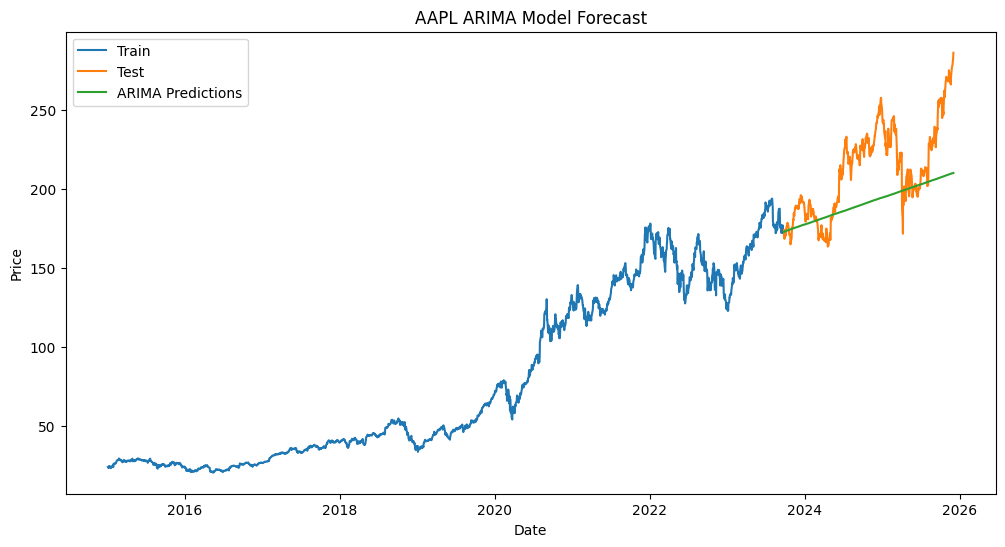

In [8]:
# Plot Actual vs Predicted

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, preds, label="ARIMA Predictions")
plt.title("AAPL ARIMA Model Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [9]:
# Print Model Summary

arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2196
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4377.962
Date:                Tue, 02 Dec 2025   AIC                           8763.925
Time:                        20:46:43   BIC                           8786.700
Sample:                             0   HQIC                          8772.248
                               - 2196                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0344      0.023      1.488      0.137      -0.011       0.080
ar.L1          0.4923      0.183      2.687      0.007       0.133       0.851
ma.L1         -0.5371      0.179     -2.997      0.003      -0.888      -0.186
sigma2         3.1618      0.047     67.140      0.000       3.070       3.254
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3814.64
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              45.28   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Arima Wrapper Function

def evaluate_arima_for_ticker(ticker):
    data = download_stock_data(ticker)
    series = data["price"]

    model, train, test, preds, metrics = train_arima(series)

    print(f"\nResults for {ticker}:")
    print(metrics)

    plt.figure(figsize=(12,6))
    plt.plot(train.index, train, label="Train")
    plt.plot(test.index, test, label="Test")
    plt.plot(test.index, preds, label="Predictions")
    plt.title(f"{ticker} ARIMA Forecast")
    plt.legend()
    plt.show()

    return metrics


/tmp/ipython-input-339415122.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8766.320, Time=5.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8765.733, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8764.438, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8764.224, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8766.908, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8763.922, Time=1.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8765.548, Time=1.81 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8765.575, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8764.133, Time=0.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8764.409, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8765.725, Time=0.35 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 12.468 seconds

Results for AAPL:
{'RMSE': np.float64(29.602216068414766), 'MAE': 23.346119042113937}


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


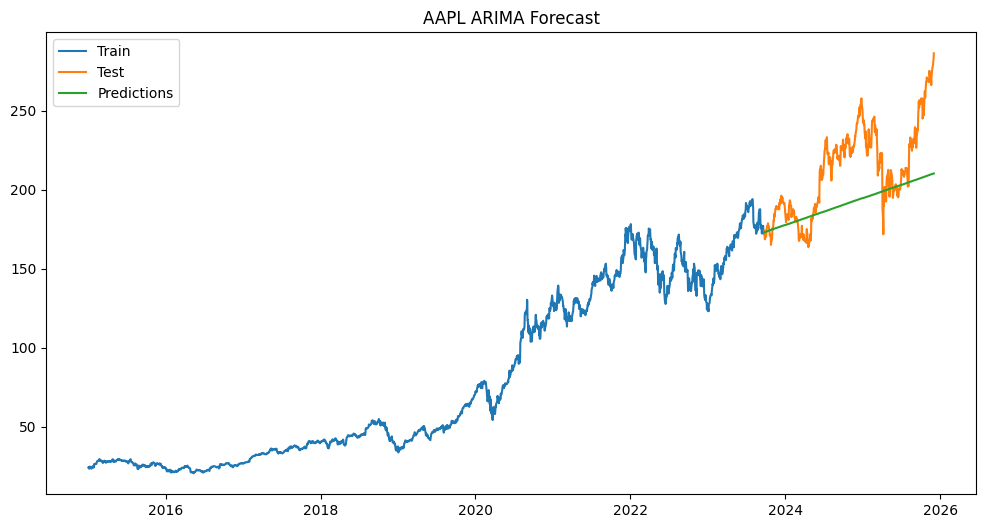

{'RMSE': np.float64(29.602216068414766), 'MAE': 23.346119042113937}

In [11]:
evaluate_arima_for_ticker("AAPL")
